# Pets Semantic Segmentation
## <font color=navy>U-Net Convolutional Neural Network

* Task of **Semantic Segmentation**:
  - Classifying each pixel as a certain class (localization)
  - Requires pixel-level labels
* Standard CNN not SOTA for task $\rightarrow$ U-Net CNN
  - Introduced in 2015 for biomedical image segmentation
  - Builds on 'full' CNN architecture
  - Relies on data augmentation
    - Model learns anomalies without being explicitly annotated in training data
    - Important for deformaties in biomedical industries, and also for infinite combinations of dogs, environments, and capture conditions (e.g. rotation, lighting, etc.) possible with pet cameras
  - Architecture is innovative
    - Contracting path to capture context
      - Same as standard CNN: repeated application of two 3x3 convolutions, followed by Rectified Linear Unit (ReLU) and 2x2 pooling operation with stride of 2 for downsampling, but also double the number of feature channels at each downsampling step
    - Symmetric expanding path that enables precise localization
      - Every step consists of upsampling feature map, then 2x2 convolution that halves the number of feature channels, concatenation of feature maps, additional 3x3 convolutions with ReLU activation, finished with 1x1 convolution that maps 64-component feature vector to number of classes
    - Total of 23 Convolutional blocks
    - Pooling operators are replaced with upsampling operators to increase the resolution of the output $\rightarrow$ high resolution features are necessary for good localization
    - Combines high resolution features with upsampled output, so next convolutional layer can learn to assemble a more precise output
    - Large number of feature channels in upsampling portion, allowing network to propagate context to higher resolution layers $\rightarrow$ creates U-shaped architecture!
    - No fully connected layers and overlap tiling strategy, which is important for larger images; otherwise, resolution would overburden GPU memory
  - Can be effectively trained on smaller datasets $\rightarrow$ helpful for tedious semantic labeling task
  - Outperforms prior best method of sliding window CNN
    - Old method is slow because it must be run separately for each window patch, and there is redundancy due to overlapping patches
    - Trade-off between localization accuracy and use of context
  - Fast on GPU $\rightarrow$ ideal for real-time video segmentation
  - Can minimize overhead by favoring large input tiles over a large batch size in training (i.e. reduce the batch size to a single image)
  - Energy function is a pixel-wise softmax over final feature map
  - Optimization: minimizing cross-entropy loss
  - Won with a large margin on the two most challenging 2D transmitted light datasets 
  - Loosely following (https://keras.io/examples/vision/oxford_pets_image_segmentation/) for architecture and training steps

* Optimization (RMSProp, Adam, Adagrad)
  - https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6
  - https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e
  - https://www.lightly.ai/post/which-optimizer-should-i-use-for-my-machine-learning-project


In [1]:
# For Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/CPE608\ Final\ Project

/content/drive/MyDrive/CPE608 Final Project


In [3]:
import numpy as np
import os
import oxford_pets_generator as op
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras 
from tensorflow.keras.layers import add, Conv2D, BatchNormalization, Activation, SeparableConv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D 
from tensorflow.keras import Model
from sklearn.metrics import classification_report

### Data Handling

In [4]:
# Load data files
train_img = np.load('data/train_img.npy')
train_masks = np.load('data/train_masks.npy')
test_img = np.load('data/test_img.npy')
test_masks = np.load('data/test_masks.npy')
val_img = np.load('data/val_img.npy')
val_masks = np.load('data/val_masks.npy')

X_train = np.load('data/X_train.npy')
y_train = np.load('data/y_train.npy')[:, :, :, 0]
X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')[:, :, :, 0]
X_val = np.load('data/X_val.npy')
y_val = np.load('data/y_val.npy')[:, :, :, 0]

# Confirm
print('Number of Training Samples: ', len(train_img))
assert len(train_img) == len(train_masks)
print('Number of Testing Samples: ', len(test_img))
assert len(test_img) == len(test_masks)
print('Number of Validation Samples: ', len(val_img))
assert len(val_img) == len(val_masks)

print()
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

Number of Training Samples:  5908
Number of Testing Samples:  738
Number of Validation Samples:  738

(5908, 160, 160, 3) (5908, 160, 160)
(738, 160, 160, 3) (738, 160, 160)
(738, 160, 160, 3) (738, 160, 160)


In [5]:
# Define parameters
img_size = (160, 160)
num_classes = 3 # Foreground, background, and ambiguous 
batch_size = 32 # In paper, suggested use 1 image per batch; however, small training data in this case

In [6]:
# Generate data sequences with custom OxfordPets generator
train_data = op.OxfordPets(batch_size, img_size, X_train, y_train)
val_data = op.OxfordPets(batch_size, img_size, X_val, y_val)

### Model Architecture

In [7]:
def UNet_CNN():
  # Define U-Net Xception model architecture
  input = keras.Input(shape = (160, 160, 3, ))

  ### First half of network - downsampling inputs
  # Entry 3x3 convolution
  x = Conv2D(32, 3, strides = 2, padding = 'same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Set aside residual
  previous_block_activation = x

  # Convolution blocks: Two 3x3 convolutions followed by 2x2 Max Pooling operation
  for filters in [64, 128, 256]:
    x = Activation('relu')(x)
    x = SeparableConv2D(filters, 3, padding = 'same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(filters, 3, padding = 'same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides = 2, padding = 'same')(x) # Strides = 2 for downsampling

    # Project residual
    residual = Conv2D(filters, 1, strides = 2, padding = 'same')(previous_block_activation)

    # Add back residual
    x = add([x, residual])

    # Set aside next residual
    previous_block_activation = x


  ### Second half of network - upsampling feature maps
  # Two 3x3 convolutions to half the number of feature channels
  for filters in [256, 128, 64, 32]:
    x = Activation('relu')(x)
    x = Conv2DTranspose(filters, 3, padding = 'same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = Conv2DTranspose(filters, 3, padding = 'same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(2)(x)

    # Project residual; upsampling followed by convolution to adjust feature map dimensions
    residual = UpSampling2D(2)(previous_block_activation)
    residual = Conv2D(filters, 1, padding = 'same')(residual)

    # Add back residual - concatenation of feature maps
    x = add([x, residual])

    # Set aside next residual
    previous_block_activation = x


  ### Per-pixel classification layer: 1x1 convolutional layer to map 64-dimensional vector to 3 classes
  output = Conv2D(num_classes, 3, activation = 'softmax', padding = 'same')(x)

  ### Build the model
  model = Model(input, output)

  return model

### Model Training

In [11]:
''' Train model '''
def train_model(train_data, val_data, file_name, optimizer):
  # Instantiate model
  model = UNet_CNN()

  # Compile model with optimizer and Sparse Categorical Cross Entropy loss
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

  # Define callbacks (ensures model saving)
  callbacks = [keras.callbacks.ModelCheckpoint(file_name, save_best_only=True)]

  # Train the model
  history = model.fit(train_data, epochs = 10, validation_data = val_data, callbacks=callbacks)

  # Plot training vs. validation loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('U-Net CNN (' + optimizer + '): Training vs. Validation Loss')
  plt.ylabel('Loss (Sparse Categorical Cross-Entropy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  return model, history

#### <font color = 'navy'> RMSProp

Epoch 1/10
184/184 [==============================] - 35s 170ms/step - loss: 1.1013 - val_loss: 2.1294
Epoch 2/10
184/184 [==============================] - 29s 160ms/step - loss: 0.5787 - val_loss: 2.0969
Epoch 3/10
184/184 [==============================] - 29s 160ms/step - loss: 0.4858 - val_loss: 0.4554
Epoch 4/10
184/184 [==============================] - 29s 155ms/step - loss: 0.4395 - val_loss: 0.4728
Epoch 5/10
184/184 [==============================] - 29s 156ms/step - loss: 0.4038 - val_loss: 0.4693
Epoch 6/10
184/184 [==============================] - 29s 159ms/step - loss: 0.3693 - val_loss: 0.4549
Epoch 7/10
184/184 [==============================] - 29s 159ms/step - loss: 0.3432 - val_loss: 0.4355
Epoch 8/10
184/184 [==============================] - 29s 159ms/step - loss: 0.3168 - val_loss: 0.3929
Epoch 9/10
184/184 [==============================] - 29s 156ms/step - loss: 0.2966 - val_loss: 0.4041
Epoch 10/10
184/184 [==============================] - 29s 157ms/step - l

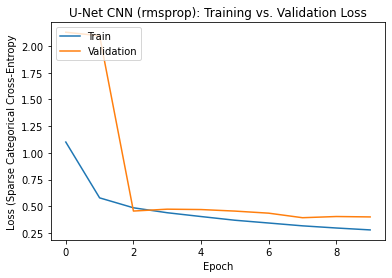

In [12]:
keras.backend.clear_session()
rmsprop_model, rmsprop_history = train_model(train_data, val_data, 'models/cnn_rmsprop.h5', 'rmsprop')

#### <font color = 'navy'> Adam

Epoch 1/10
184/184 [==============================] - 32s 161ms/step - loss: 0.8676 - val_loss: 2.6894
Epoch 2/10
184/184 [==============================] - 28s 154ms/step - loss: 0.5718 - val_loss: 3.6176
Epoch 3/10
184/184 [==============================] - 29s 159ms/step - loss: 0.4937 - val_loss: 1.3005
Epoch 4/10
184/184 [==============================] - 29s 157ms/step - loss: 0.4504 - val_loss: 0.5167
Epoch 5/10
184/184 [==============================] - 29s 157ms/step - loss: 0.4234 - val_loss: 0.4559
Epoch 6/10
184/184 [==============================] - 29s 158ms/step - loss: 0.3972 - val_loss: 0.4365
Epoch 7/10
184/184 [==============================] - 29s 157ms/step - loss: 0.3682 - val_loss: 0.4274
Epoch 8/10
184/184 [==============================] - 29s 157ms/step - loss: 0.3389 - val_loss: 0.4005
Epoch 9/10
184/184 [==============================] - 28s 153ms/step - loss: 0.3176 - val_loss: 0.4084
Epoch 10/10
184/184 [==============================] - 28s 153ms/step - l

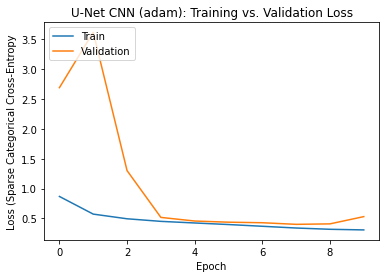

In [13]:
keras.backend.clear_session()
adam_model, adam_history = train_model(train_data, val_data, 'models/cnn_adam.h5', 'adam')

#### <font color = 'navy'> Adagrad

Epoch 1/10
184/184 [==============================] - 52s 159ms/step - loss: 1.1999 - val_loss: 1.5317
Epoch 2/10
184/184 [==============================] - 28s 152ms/step - loss: 0.8463 - val_loss: 1.8795
Epoch 3/10
184/184 [==============================] - 29s 156ms/step - loss: 0.7722 - val_loss: 0.9800
Epoch 4/10
184/184 [==============================] - 29s 156ms/step - loss: 0.7380 - val_loss: 0.7170
Epoch 5/10
184/184 [==============================] - 29s 156ms/step - loss: 0.7134 - val_loss: 0.6992
Epoch 6/10
184/184 [==============================] - 29s 156ms/step - loss: 0.6971 - val_loss: 0.6797
Epoch 7/10
184/184 [==============================] - 29s 156ms/step - loss: 0.6824 - val_loss: 0.6762
Epoch 8/10
184/184 [==============================] - 29s 156ms/step - loss: 0.6720 - val_loss: 0.6632
Epoch 9/10
184/184 [==============================] - 29s 157ms/step - loss: 0.6610 - val_loss: 0.6526
Epoch 10/10
184/184 [==============================] - 29s 156ms/step - l

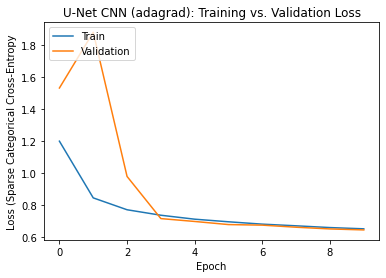

In [14]:
keras.backend.clear_session()
adagrad_model, adagrad_history = train_model(train_data, val_data, 'models/cnn_adagrad.h5', 'adagrad')

### Evaluation

In [15]:
''' Get prediction vectors '''
def get_predictions(model):
  # Get predictions as probability vector, then discrete vector (add 1 to account for index)
  train_pred = model.predict(X_train)
  train_pred_vec = np.argmax(train_pred, axis=-1) + 1

  val_pred = model.predict(X_val)
  val_pred_vec = np.argmax(val_pred, axis=-1) + 1

  test_pred = model.predict(X_test)
  test_pred_vec = np.argmax(test_pred, axis=-1) + 1

  return train_pred_vec, val_pred_vec, test_pred_vec

In [18]:
# RMSProp
rms_train, rms_val, rms_test = get_predictions(rmsprop_model)

In [19]:
# Adam
adam_train, adam_val, adam_test = get_predictions(adam_model)

In [20]:
# Adagrad
adagrad_train, adagrad_val, adagrad_test = get_predictions(adagrad_model) 

In [22]:
# Write to files
np.save('data/preds/unet_rmsprop_train.npy', rms_train)
np.save('data/preds/unet_rmsprop_val.npy', rms_val)
np.save('data/preds/unet_rmsprop_test.npy', rms_test)

np.save('data/preds/unet_adam_train.npy', adam_train)
np.save('data/preds/unet_adam_val.npy', adam_val)
np.save('data/preds/unet_adam_test.npy', adam_test)

np.save('data/preds/unet_adagrad_train.npy', adagrad_train)
np.save('data/preds/unet_adagrad_val.npy', adagrad_val)
np.save('data/preds/unet_adagrad_test.npy', adagrad_test)